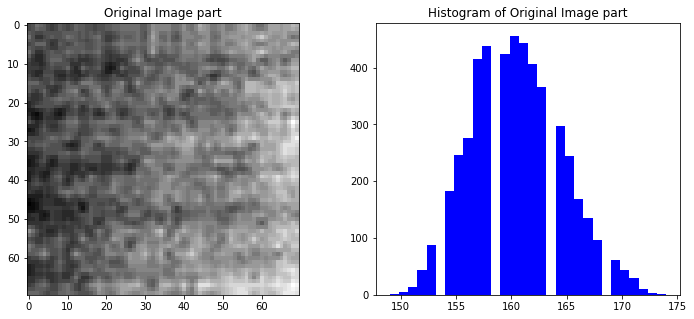

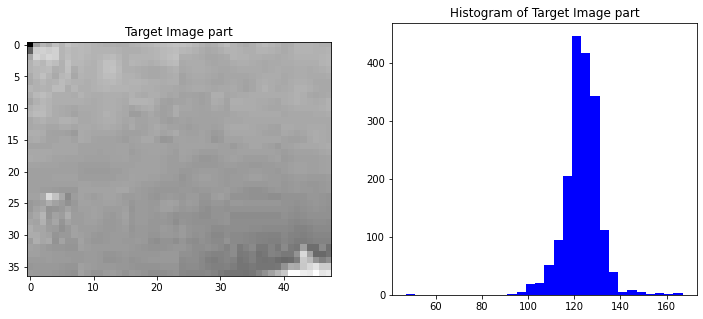

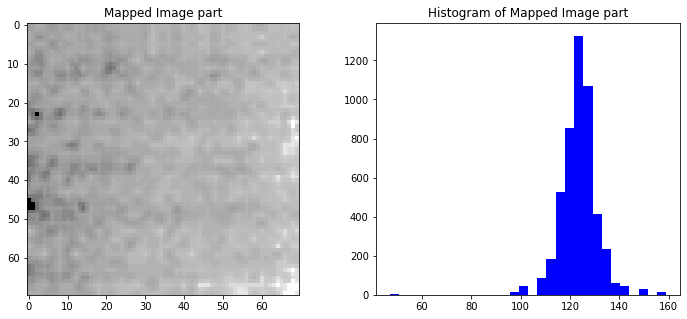

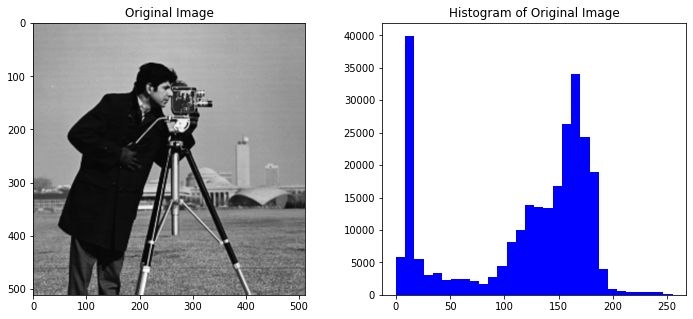

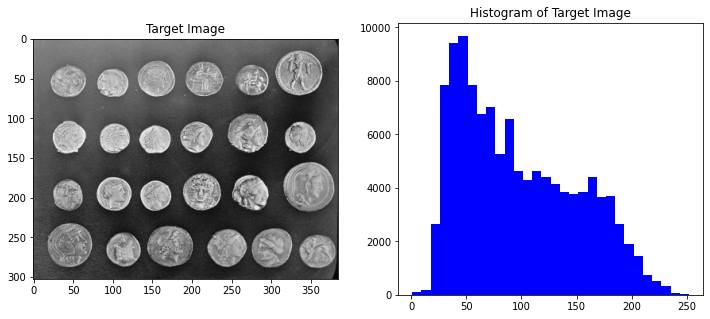

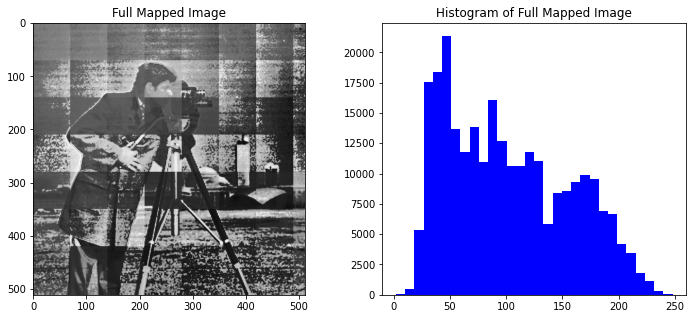

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import math
from skimage.color import rgb2gray



def match_hist(source_im, target_im):

    oldshape = source_im.shape
    original = source_im.ravel()
    target = target_im.ravel()

    original_values, bin_idx, original_counts  = np.unique(original, return_inverse=True, return_counts=True)
    target_values, target_counts = np.unique(target, return_counts=True)

    original_quantiles = np.cumsum(original_counts).astype(np.float64)
    original_quantiles = original_quantiles / original_quantiles[len(original_quantiles)-1]

    target_quantiles = np.cumsum(target_counts).astype(np.float64)
    target_quantiles = target_quantiles / target_quantiles[len(target_quantiles)-1]

    original_round = np.around(original_quantiles*255)
    target_round = np.around(target_quantiles*255)

    mapped = []
    for data in original_round[:]:
        diff = target_round - data
        if np.all(np.ma.less_equal(diff, -1)):
            mapped.append(np.abs(diff).argmin())
        else:
            mapped.append(np.ma.masked_array(diff, np.ma.less_equal(diff, -1)).argmin())
    mapped = np.array(mapped,dtype='uint8')
    return target_values[mapped[bin_idx]].reshape(oldshape)

def plot_hist_img(image, title):

    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(image,cmap='gray')
    plt.title(title)
    plt.subplot(122)
    plt.hist(image.ravel(),bins=30,color='blue')
    plt.title('Histogram of '+ title)


def adap_hist_matching(source_im,target_im,D):

    if D < 1 or D > source_im.shape[0] or D > source_im.shape[1]:
        return
    if np.max(source_im) < 2 :
        source_im = np.array((source_im*255),dtype='uint8')

    if np.max(target_im) < 2 :
        target_im = np.array((target_im*255),dtype='uint8')

    o_rows, o_cols = source_im.shape
    t_rows, t_cols = target_im.shape

    a_mod = o_rows%D
    if a_mod > 0:
        a = math.floor(o_rows/D) + 1
    else:
        a = math.floor(o_rows/D)

    b_mod = o_cols%D
    if b_mod > 0:
        b = math.floor(o_cols/D) + 1
    else:
        b = math.floor(o_cols/D)

    c = math.floor(t_rows/a)
    d = math.floor(t_cols/b)

    if c <= 0 or d <= 0:
        return

    list_rows = []
    list_cols = []

    for i in range(0, o_rows, D):
        list_rows.append(i)
    list_rows.append(o_rows)

    for i in range(0, o_cols, D):
        list_cols.append(i)
    list_cols.append(o_cols)

    list_rows_t = []
    list_cols_t = []

    for i in range(0, t_rows, c):
        list_rows_t.append(i)
    list_rows_t.append(t_rows)

    for i in range(0, t_cols, d):
        list_cols_t.append(i)
    list_cols_t.append(t_cols)

    out_im = np.zeros((o_rows, o_cols),dtype='uint8')

    for i in range(0,len(list_cols)-1):
        for j in range(0,len(list_rows)-1):
            out_im[list_rows[j]:list_rows[j]+D,list_cols[i]:list_cols[i]+D] = match_hist(source_im[list_rows[j]:list_rows[j]+D,list_cols[i]:list_cols[i]+D],target_im[list_rows_t[j]:list_rows_t[j]+c,list_cols_t[i]:list_cols_t[i]+d])
            if i==0 and j==0:
                plot_hist_img(source_im[list_rows[j]:list_rows[j]+D,list_cols[i]:list_cols[i]+D] ,'Original Image part')
                plot_hist_img(target_im[list_rows_t[j]:list_rows_t[j]+c,list_cols_t[i]:list_cols_t[i]+d] ,'Target Image part')
                plot_hist_img(out_im[list_rows[j]:list_rows[j]+D,list_cols[i]:list_cols[i]+D] ,'Mapped Image part')

    return out_im



original = data.camera()
target = data.coins()
a = adap_hist_matching(original,target,70)

plot_hist_img(original,'Original Image')
plot_hist_img(target,'Target Image')
plot_hist_img(a,'Full Mapped Image')



